In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import random
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, RobustScaler
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, silhouette_score, classification_report
from sklearn.cluster import DBSCAN, KMeans
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, train_test_split

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
import matplotlib
from matplotlib import font_manager

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv

fontpaths = ["/usr/share/fonts/truetype/nanum/"]
font_files = font_manager.findSystemFonts(fontpaths=fontpaths)

for ff in font_files:
    font_manager.fontManager.addfont(ff)

matplotlib.rc('font', family="NanumGothic")
matplotlib.rcParams['axes.unicode_minus'] = False

# 데이터 불러오기 및 전처리

In [ ]:
DATA_PATH = "/content/drive/MyDrive/멋쟁이사자처럼/DataThon/dataset/Moulding/"
SEED = 42
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
train_cn7 = pd.read_csv(f"{DATA_PATH}train_cn7.csv")    # 정상 0
test_cn7 = pd.read_csv(f"{DATA_PATH}test_cn7.csv")  # 정상 0 + 불량 1
train_rg3 = pd.read_csv(f"{DATA_PATH}train_rg3.csv")    # 정상 0
test_rg3 = pd.read_csv(f"{DATA_PATH}test_rg3.csv")  # 정상 0 + 불량 1
unlabeled = pd.read_csv(f"{DATA_PATH}unlabeled_data.csv")
unlab_cn7 = pd.read_csv(f"{DATA_PATH}unlab_cn7.csv")
unlab_rg3 = pd.read_csv(f"{DATA_PATH}unlab_rg3.csv")

train_cn7.shape, test_cn7.shape, train_rg3.shape, test_rg3.shape, unlab_cn7.shape, unlab_rg3.shape

((2400, 45), (1574, 45), (750, 45), (506, 45), (52547, 46), (37477, 46))

In [ ]:
unlab_cn7.drop(columns=["Unnamed: 0"], inplace=True)
unlab_rg3.drop(columns=["Unnamed: 0"], inplace=True)

In [ ]:
train_cn7['PART_FACT_SERIAL'] = train_cn7['PART_FACT_SERIAL'].astype(object)
test_cn7['PART_FACT_SERIAL'] = test_cn7['PART_FACT_SERIAL'].astype(object)
unlab_cn7['PART_FACT_SERIAL'] = unlab_cn7['PART_FACT_SERIAL'].astype(object)

train_rg3['PART_FACT_SERIAL'] = train_rg3['PART_FACT_SERIAL'].astype(object)
test_rg3['PART_FACT_SERIAL'] = test_rg3['PART_FACT_SERIAL'].astype(object)
unlab_rg3['PART_FACT_SERIAL'] = unlab_rg3['PART_FACT_SERIAL'].astype(object)

In [ ]:
lab_cn7 = pd.concat([train_cn7, test_cn7], axis=0)
lab_rg3 = pd.concat([train_rg3, test_rg3], axis=0)

lab_cn7.shape, lab_rg3.shape

((3974, 45), (1256, 45))

In [ ]:
cn7_serial = lab_cn7["PART_FACT_SERIAL"].unique().tolist()
rg3_serial = lab_rg3["PART_FACT_SERIAL"].unique().tolist()

In [ ]:
# EQUIP_NAME, EQUIP_CD 650톤-우진2호기만 남기고 나머지 제외
# PART_FACT_SERIAL train과 똑같이 적용
# Switch_Over_Position이 0
unlab_cn7 = unlab_cn7[unlab_cn7["EQUIP_NAME"] == "650톤-우진2호기"]
unlab_cn7 = unlab_cn7[unlab_cn7["PART_FACT_SERIAL"].isin(cn7_serial)]
unlab_cn7 = unlab_cn7[unlab_cn7["Switch_Over_Position"] == 0]

unlab_rg3 = unlab_rg3[unlab_rg3["EQUIP_NAME"] == "650톤-우진2호기"]
unlab_rg3 = unlab_rg3[unlab_rg3["PART_FACT_SERIAL"].isin(rg3_serial)]
unlab_rg3 = unlab_rg3[unlab_rg3["Switch_Over_Position"] == 0]

unlab_cn7.shape, unlab_rg3.shape

((10048, 45), (16480, 45))

In [ ]:
train_cn7_ft = train_cn7.copy()
test_cn7_ft = test_cn7.copy()
unlab_cn7_ft = unlab_cn7.copy()

train_cn7_ft.shape, test_cn7_ft.shape, unlab_cn7_ft.shape

((2400, 45), (1574, 45), (10048, 45))

In [ ]:
train_rg3_ft = train_rg3.copy()
test_rg3_ft = test_rg3.copy()
unlab_rg3_ft = unlab_rg3.copy()

train_rg3_ft.shape, test_rg3_ft.shape, unlab_rg3_ft.shape

((750, 45), (506, 45), (16480, 45))

In [ ]:
train_cn7_ft = lab_cn7[:train_cn7_ft.shape[0]].copy()
test_cn7_ft = lab_cn7[train_cn7_ft.shape[0]:].copy()

train_cn7_ft.shape, test_cn7_ft.shape, unlab_cn7_ft.shape

((2400, 45), (1574, 45), (10048, 45))

In [ ]:
train_rg3_ft = lab_rg3[:train_rg3_ft.shape[0]].copy()
test_rg3_ft = lab_rg3[train_rg3_ft.shape[0]:].copy()

train_rg3_ft.shape, test_rg3_ft.shape, unlab_rg3_ft.shape

((750, 45), (506, 45), (16480, 45))

In [ ]:
label_drop_cols = ["_id", "TimeStamp", "PART_FACT_PLAN_DATE", "EQUIP_CD", "EQUIP_NAME", "PassOrFail", "Reason", 'Barrel_Temperature_7',
             'Mold_Temperature_1', 'Mold_Temperature_2', 'Mold_Temperature_5', 'Mold_Temperature_6', 'Mold_Temperature_7',
             'Mold_Temperature_8', 'Mold_Temperature_9', 'Mold_Temperature_10', 'Mold_Temperature_11', 'Mold_Temperature_12']

In [ ]:
unlab_cn7_drop_cols = [col for col in unlab_cn7_ft.columns if col not in train_cn7_ft.columns] + [col for col in label_drop_cols if col in unlab_cn7_ft.columns]
unlab_rg3_drop_cols = [col for col in unlab_rg3_ft.columns if col not in train_rg3_ft.columns] + [col for col in label_drop_cols if col in unlab_rg3_ft.columns]

In [ ]:
# 학습용 정답데이터 => 제품마다 코드 수정 필요
y_train = (train_cn7['PassOrFail'] == 'N').astype(int)
y_train.shape

(2400,)

In [ ]:
# 테스트용 정답데이터 => 제품마다 코드 수정 필요
target = (test_cn7['PassOrFail'] == 'N').astype(int)
target.shape

(1574,)

- cn7

In [ ]:
train_ft = train_cn7_ft.drop(label_drop_cols, axis=1).copy()
test_ft = test_cn7_ft.drop(label_drop_cols, axis=1).copy()
unlab_ft = unlab_cn7_ft.drop(unlab_cn7_drop_cols, axis=1).copy()
train_ft.shape, test_ft.shape, unlab_ft.shape

((2400, 27), (1574, 27), (10048, 27))

- rg3

In [ ]:
# train_ft = train_rg3_ft.drop(label_drop_cols, axis=1).copy()
# test_ft = test_rg3_ft.drop(label_drop_cols, axis=1).copy()
# unlab_ft = unlab_rg3_ft.drop(unlab_rg3_drop_cols, axis=1).copy()
# train_ft.shape, test_ft.shape, unlab_ft.shape

In [ ]:
train_ft.drop(columns=["Switch_Over_Position"], inplace=True)
test_ft.drop(columns=["Switch_Over_Position"], inplace=True)
unlab_ft.drop(columns=["Switch_Over_Position"], inplace=True)

train_ft.shape, test_ft.shape, unlab_ft.shape

((2400, 26), (1574, 26), (10048, 26))

In [ ]:
def preprocess(df, test=False, enc=None, scaler=None):
    obj_col = df.select_dtypes('object').columns

    if not(test):
        enc = OneHotEncoder(handle_unknown='ignore')
        enc.fit(df[obj_col])
    df[enc.get_feature_names_out()] = enc.transform(df[obj_col]).toarray()
    df.drop(obj_col, axis=1, inplace=True)

    if not(test):
        scaler = RobustScaler()
        scaler.fit(df)
    df = scaler.transform(df)

    return df, enc, scaler

In [ ]:
train_ft, enc, scaler = preprocess(train_ft)
test_ft, _, _ = preprocess(test_ft, test=True, enc=enc, scaler=scaler)
unlab_ft, _, _ = preprocess(unlab_ft, test=True, enc=enc, scaler=scaler)

In [ ]:
train_ft.shape, test_ft.shape, unlab_ft.shape

((2400, 34), (1574, 34), (10048, 34))

# 비지도 모델링

## DBSCAN

### CN7

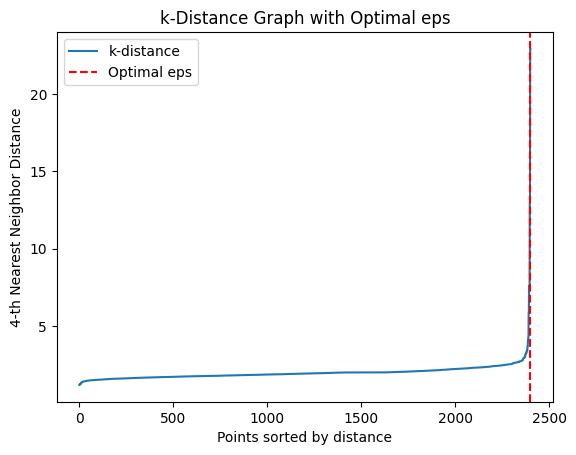

Optimal eps: 12.991


In [4]:
from sklearn.neighbors import NearestNeighbors

# k = min_samples - 1
min_samples = 5
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(train_ft)
distances, indices = neighbors_fit.kneighbors(train_ft)

# 거리 정렬
distances = np.sort(distances[:, -1])  # k번째 이웃 거리

# 1차 차분(기울기)
diff = np.diff(distances)

# 2차 차분(기울기 변화)
diff2 = np.diff(diff)

# 최대 기울기 변화 지점 찾기
elbow_index = np.argmax(diff2) + 1  # +1은 diff 차원 감소 보정

# 시각화
plt.plot(distances, label="k-distance")
plt.axvline(x=elbow_index, color="r", linestyle="--", label="Optimal eps")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{min_samples - 1}-th Nearest Neighbor Distance")
plt.legend()
plt.title("k-Distance Graph with Optimal eps")
plt.show()

print(f"Optimal eps: {distances[elbow_index]:.3f}")

#### 이상치 비율 및 실루엣 점수
- 초기 파라미터 [eps : 0.5, min_samples : 10]
- 0109EDA 반영
    - 0.13% / 0.7964
- 0109EDA 반영 / eps : 0.528, min_samples : 37
    - 0.20% / 0.8506
- 0109EDA 반영 / Switch_Over_Position == 0
    - 0.86% / 0.7320
- 0109EDA 반영 / Switch_Over_Position == 0 / eps : 0.528, min_samples : 37
    - 1.12% / 0.7312
- 0109EDA 반영 / Switch_Over_Position == 0 필터링 후 Switch_Over_Position 삭제 / eps : 0.528, min_samples : 37
    - 1.12% / 0.7312
    - 필터링 후 삭제해도 영향 없는 것 같음
- 0109EDA 반영 / Switch_Over_Position == 0 / Switch_Over_Position, Mold_Temperature_3, Mold_Temperature_4 삭제 / eps : 0.525, min_samples : 35
    - 0.89%, 0.8271


In [ ]:
model = DBSCAN(eps=0.528,
               min_samples=36,
               metric='euclidean',
               n_jobs=-1)

model.fit(train_ft)

DBSCAN(eps=0.528, min_samples=36, n_jobs=-1)

In [ ]:
pred = model.fit_predict(train_ft)

normal = train_ft[pred != -1]
anomalies = train_ft[pred == -1]
ratio = len(anomalies) / len(train_ft)

print(f"정상 : {len(normal)}, 이상치 : {len(anomalies)}, 이상치 비율 : {ratio:.4f}")

labels = pred[pred != -1]

sil_score = silhouette_score(normal, labels)
print(f"Silhouette Score: {sil_score:.4f}")

정상 : 2384, 이상치 : 16, 이상치 비율 : 0.0067
Silhouette Score: 0.9961


In [ ]:
pred_dbscan = model.fit_predict(unlab_ft)

normal = unlab_ft[pred_dbscan != -1]
anomalies = unlab_ft[pred_dbscan == -1]
ratio = len(anomalies) / len(unlab_ft)

print(f"정상 : {len(normal)}, 이상치 : {len(anomalies)}, 이상치 비율 : {ratio:.4f}")

labels = pred_dbscan[pred_dbscan != -1]

sil_score = silhouette_score(normal, labels)
print(f"Silhouette Score: {sil_score:.4f}")

정상 : 9986, 이상치 : 62, 이상치 비율 : 0.0062
Silhouette Score: 0.8916


In [ ]:
pred = model.fit_predict(test_ft)

normal = test_ft[pred != -1]
anomalies = test_ft[pred == -1]
ratio = len(anomalies) / len(test_ft)

print(f"정상 : {len(normal)}, 이상치 : {len(anomalies)}, 이상치 비율 : {ratio:.4f}")

정상 : 1541, 이상치 : 33, 이상치 비율 : 0.0210


In [ ]:
pred = np.where(pred == -1, 1, 0)
print(f"f1_score : {f1_score(target, pred):.4f}")
print(classification_report(target, pred))

f1_score : 0.8852
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1546
           1       0.82      0.96      0.89        28

    accuracy                           1.00      1574
   macro avg       0.91      0.98      0.94      1574
weighted avg       1.00      1.00      1.00      1574



### RG3

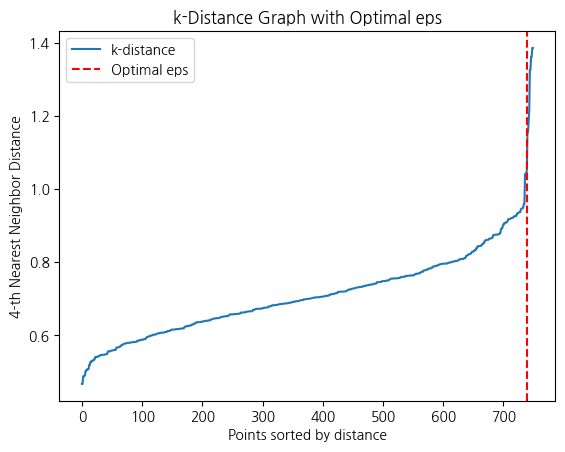

Optimal eps: 1.053


In [ ]:
# k = min_samples - 1
min_samples = 5
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(train_ft)
distances, indices = neighbors_fit.kneighbors(train_ft)

# 거리 정렬
distances = np.sort(distances[:, -1])  # k번째 이웃 거리

# 1차 차분(기울기)
diff = np.diff(distances)

# 2차 차분(기울기 변화)
diff2 = np.diff(diff)

# 최대 기울기 변화 지점 찾기
elbow_index = np.argmax(diff2) + 1  # +1은 diff 차원 감소 보정

# 시각화
plt.plot(distances, label="k-distance")
plt.axvline(x=elbow_index, color="r", linestyle="--", label="Optimal eps")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{min_samples - 1}-th Nearest Neighbor Distance")
plt.legend()
plt.title("k-Distance Graph with Optimal eps")
plt.show()

print(f"Optimal eps: {distances[elbow_index]:.3f}")

#### 이상치 비율 및 실루엣 점수
- 초기 파라미터 [eps : 0.5, min_samples : 10]
- 0109EDA 반영
    - 24.48% / 0.2281
- 0109EDA 반영 / eps : 0.959, min_samples : 35
    - 27.26% / 0.2985
- 0109EDA 반영 / Switch_Over_Position == 0
    - 97.54% / 0.8120
- 0109EDA 반영 / Switch_Over_Position == 0 / eps : 0.959, min_samples : 35
    - 27.14% / 0.3102
- 0109EDA 반영 / Switch_Over_Position == 0 / Switch_Over_Position 삭제 / eps : 1.053, min_samples : 34
    - 23.56% / 0.3068



In [ ]:
model = DBSCAN(eps=1.053,
               min_samples=34,
               metric='euclidean',
               n_jobs=-1)

model.fit(train_ft)

DBSCAN(eps=1.053, min_samples=34, n_jobs=-1)

In [ ]:
pred_dbscan = model.fit_predict(train_ft)

normal = train_ft[pred_dbscan != -1]
anomalies = train_ft[pred_dbscan == -1]
ratio = len(anomalies) / len(train_ft)

print(f"정상 : {len(normal)}, 이상치 : {len(anomalies)}, 이상치 비율 : {ratio:.4f}")

labels = pred_dbscan[pred_dbscan != -1]

sil_score = silhouette_score(normal, labels)
print(f"Silhouette Score: {sil_score:.4f}")

정상 : 657, 이상치 : 93, 이상치 비율 : 0.1240
Silhouette Score: 0.3583


In [ ]:
pred_dbscan = model.fit_predict(unlab_ft)

normal = unlab_ft[pred_dbscan != -1]
anomalies = unlab_ft[pred_dbscan == -1]
ratio = len(anomalies) / len(unlab_ft)

print(f"정상 : {len(normal)}, 이상치 : {len(anomalies)}, 이상치 비율 : {ratio:.4f}")

labels = pred_dbscan[pred_dbscan != -1]

sil_score = silhouette_score(normal, labels)
print(f"Silhouette Score: {sil_score:.4f}")

정상 : 12598, 이상치 : 3882, 이상치 비율 : 0.2356
Silhouette Score: 0.3068


In [ ]:
pred = model.fit_predict(test_ft)

normal = test_ft[pred != -1]
anomalies = test_ft[pred == -1]
ratio = len(anomalies) / len(test_ft)

print(f"정상 : {len(normal)}, 이상치 : {len(anomalies)}, 이상치 비율 : {ratio:.4f}")

labels = pred[pred != -1]

sil_score = silhouette_score(normal, labels)
print(f"Silhouette Score: {sil_score:.4f}")

정상 : 306, 이상치 : 200, 이상치 비율 : 0.3953
Silhouette Score: 0.4680


In [ ]:
pred = np.where(pred == -1, 1, 0)
print(f"f1_score : {f1_score(target, pred):.4f}")
print(classification_report(target, pred))

f1_score : 0.2241
              precision    recall  f1-score   support

           0       0.98      0.63      0.77       474
           1       0.13      0.81      0.22        32

    accuracy                           0.64       506
   macro avg       0.56      0.72      0.50       506
weighted avg       0.93      0.64      0.73       506



## K-Means

### CN7

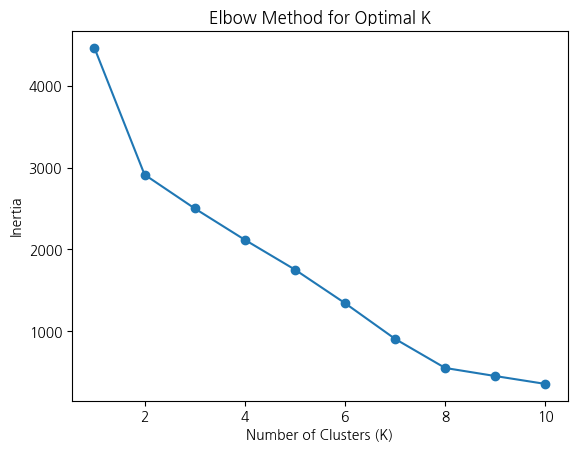

In [ ]:
# inertia_values = []
# k_range = range(1, 11)

# for k in k_range:
#     kmeans = KMeans(n_clusters=k, random_state=SEED)
#     kmeans.fit(train_ft)
#     inertia_values.append(kmeans.inertia_)

# # Elbow Method 시각화
# plt.plot(k_range, inertia_values, marker='o')
# plt.xlabel('Number of Clusters (K)')
# plt.ylabel('Inertia')
# plt.title('Elbow Method for Optimal K')
# plt.show()

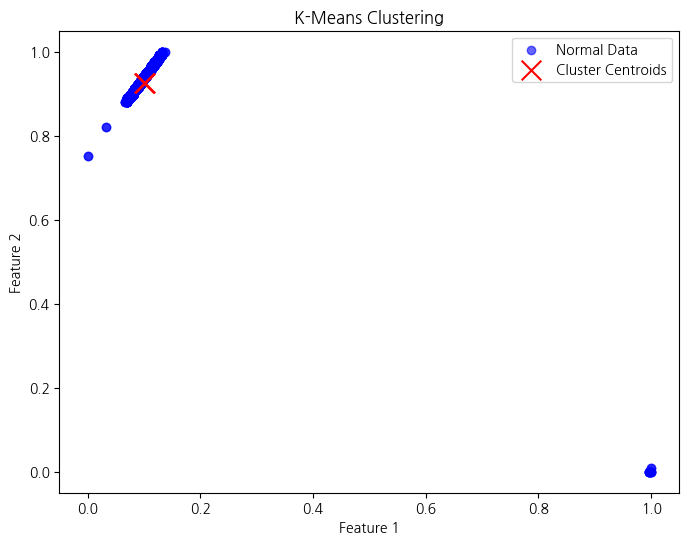

In [ ]:
model = KMeans(n_clusters=2, random_state=SEED)
model.fit(train_ft)

cluster_labels = model.predict(train_ft)

# 군집 중심
centroids = model.cluster_centers_

# 군집화된 데이터 시각화
plt.figure(figsize=(8, 6))

# 정상 데이터와 예측된 레이블에 따라 색상 지정
plt.scatter(train_ft[:, 0], train_ft[:, 1], c='blue', label='Normal Data', alpha=0.6)  # 정상 데이터 (train_ft)

# 군집 중심 표시
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, label='Cluster Centroids')

plt.title("K-Means Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

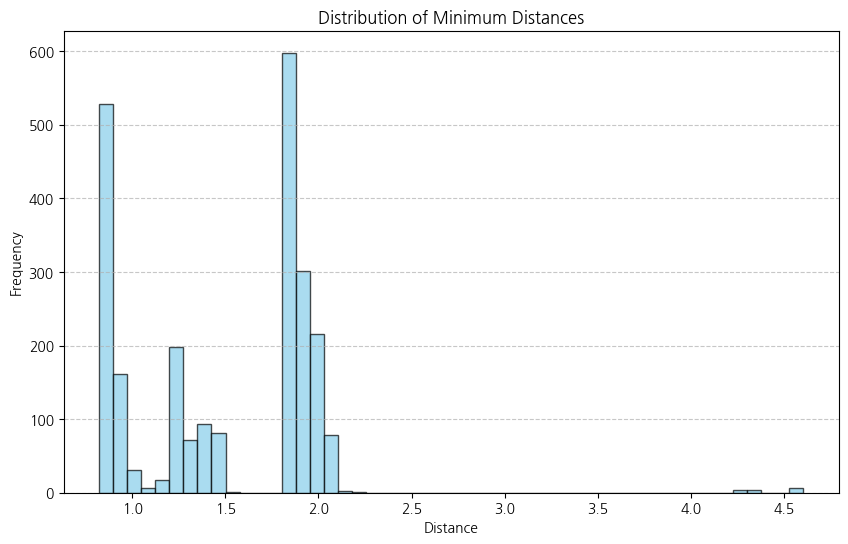

In [ ]:
distances = model.transform(train_ft)   # 클러스터 중심간의 거리
min_distances = distances[:, 0]

# 히스토그램 시각화
plt.figure(figsize=(10, 6))
plt.hist(min_distances, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Distribution of Minimum Distances")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
cluster_labels = model.predict(train_ft)
threshold = 2.0
is_anomaly = min_distances > threshold

normal_data = train_ft[~is_anomaly]
anomalies = train_ft[is_anomaly]
ratio = len(anomalies) / len(train_ft)

print(f"정상 데이터 개수: {len(normal_data)}")
print(f"이상치 데이터 개수: {len(anomalies)}")
print(f"이상치 비율 : {ratio:.4f}")

sil_score = silhouette_score(train_ft, cluster_labels)
print(f"Silhouette Score: {sil_score:.4f}")

정상 데이터 개수: 2285
이상치 데이터 개수: 115
이상치 비율 : 0.0479
Silhouette Score: 0.3777


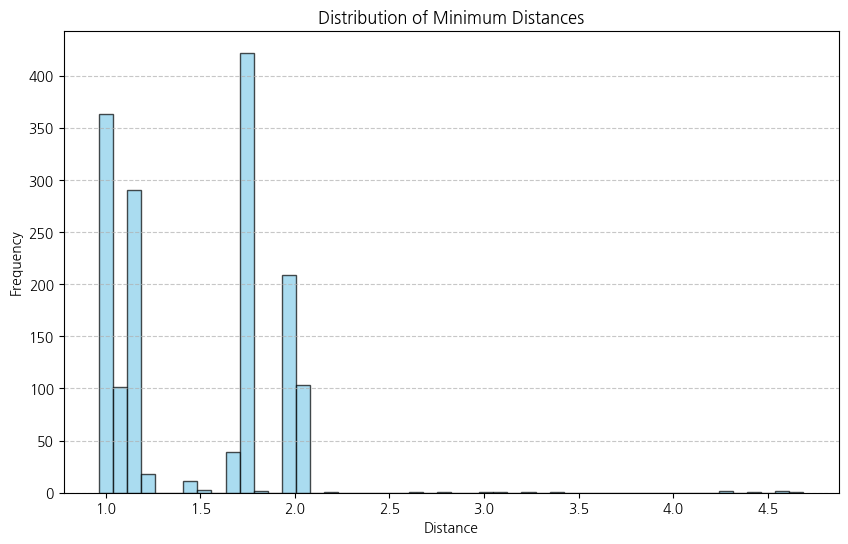

In [ ]:
distances = model.transform(test_ft)   # 클러스터 중심간의 거리
min_distances = distances[:, 0]

# 히스토그램 시각화
plt.figure(figsize=(10, 6))
plt.hist(min_distances, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Distribution of Minimum Distances")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
np.percentile(min_distances, 95)

2.0128230587389195

In [ ]:
distances = model.transform(test_ft)
min_distances = distances[:, 0]

cluster_labels = model.predict(test_ft)
threshold = np.percentile(min_distances, 95)
is_anomaly = min_distances > threshold

normal_data = test_ft[~is_anomaly]
anomalies = test_ft[is_anomaly]
ratio = len(anomalies) / len(test_ft)

print(f"정상 데이터 개수: {len(normal_data)}")
print(f"이상치 데이터 개수: {len(anomalies)}")
print(f"이상치 비율 : {ratio:.4f}")

sil_score = silhouette_score(test_ft, cluster_labels)
print(f"Silhouette Score: {sil_score:.4f}")

정상 데이터 개수: 1495
이상치 데이터 개수: 79
이상치 비율 : 0.0502
Silhouette Score: 0.5969


In [ ]:
pred = np.where(min_distances > threshold, 1, 0)
print(f"f1_score : {f1_score(target, pred):.4f}")
print(classification_report(target, pred))

f1_score : 0.1495
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1546
           1       0.10      0.29      0.15        28

    accuracy                           0.94      1574
   macro avg       0.54      0.62      0.56      1574
weighted avg       0.97      0.94      0.96      1574



### RG3

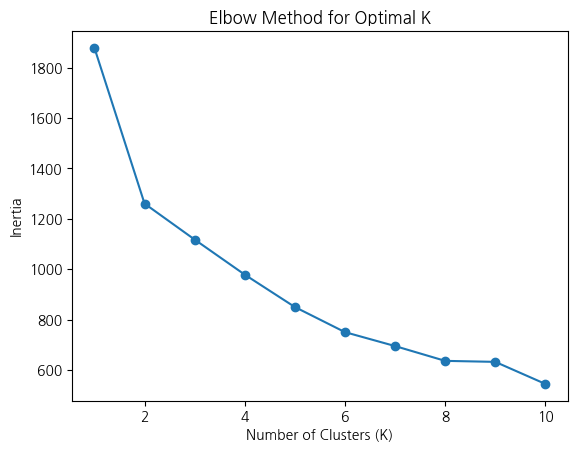

In [ ]:
inertia_values = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=SEED)
    kmeans.fit(train_ft)
    inertia_values.append(kmeans.inertia_)

# Elbow Method 시각화
plt.plot(k_range, inertia_values, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

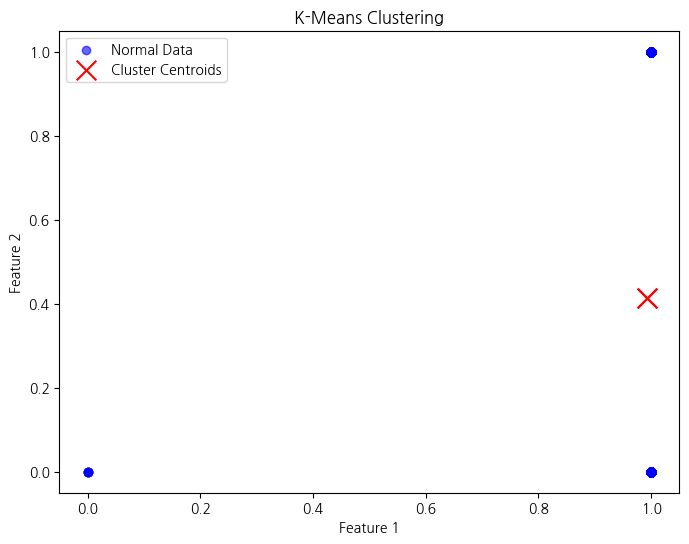

In [ ]:
model = KMeans(n_clusters=2, random_state=SEED)
model.fit(train_ft)

cluster_labels = model.predict(train_ft)

# 군집 중심
centroids = model.cluster_centers_

# 군집화된 데이터 시각화
plt.figure(figsize=(8, 6))

# 정상 데이터와 예측된 레이블에 따라 색상 지정
plt.scatter(train_ft[:, 0], train_ft[:, 1], c='blue', label='Normal Data', alpha=0.6)  # 정상 데이터 (train_ft)

# 군집 중심 표시
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, label='Cluster Centroids')

plt.title("K-Means Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [ ]:
distances = model.transform(unlab_ft)   # 클러스터 중심간의 거리
min_distances = distances[:, 0]

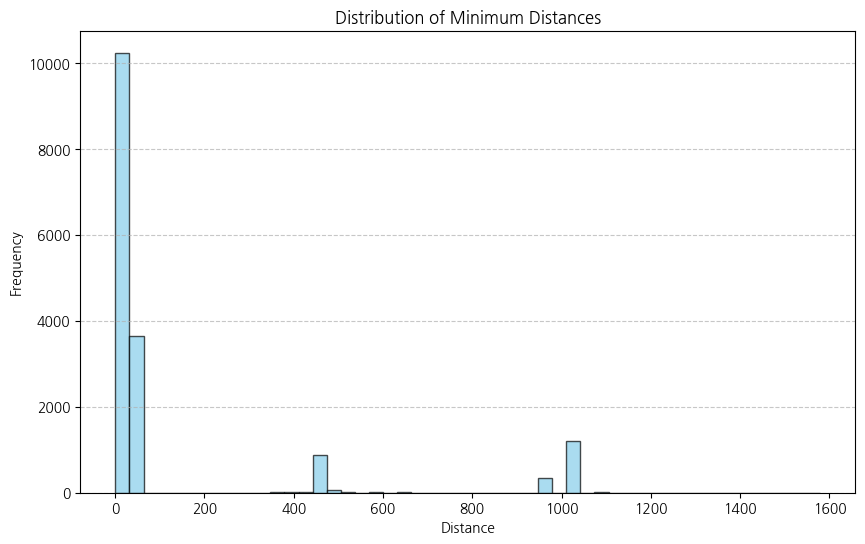

In [ ]:
# 히스토그램 시각화
plt.figure(figsize=(10, 6))
plt.hist(min_distances, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Distribution of Minimum Distances")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
distances = model.transform(unlab_ft)   # 클러스터 중심간의 거리
min_distances = distances[:, 0]

cluster_labels = model.predict(unlab_ft)
threshold = 450
is_anomaly = min_distances > threshold

normal_data = unlab_ft[~is_anomaly]
anomalies = unlab_ft[is_anomaly]
ratio = len(anomalies) / len(unlab_ft)

print(f"정상 데이터 개수: {len(normal_data)}")
print(f"이상치 데이터 개수: {len(anomalies)}")
print(f"이상치 비율 : {ratio:.4f}")

sil_score = silhouette_score(unlab_ft, cluster_labels)
print(f"Silhouette Score: {sil_score:.4f}")

정상 데이터 개수: 14729
이상치 데이터 개수: 1751
이상치 비율 : 0.1062
Silhouette Score: 0.0582
